In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
plt.rcParams['axes.grid'] = True
plt.rcParams['image.aspect'] = 0.8

import numpy as np
import casadi as ca
import time
from helper_fns import *

def timed_exec(fn, *args):
    start = time.time()
    res = fn(*args)
    elapsed = time.time() - start
    return elapsed, *res

In [4]:
## MPC only, i.e. without iCEM warmstart
mpc, params = spawn_mpc()

params['belief_free'] = 1.0
params['belief_point'] = 0.0

t_mpc_free_cold, cost, res = timed_exec(mpc.solve, params)
t_mpc_free_warm, cost_free, res = timed_exec(mpc.solve, params)

params['belief_free'] = 0.0
params['belief_point'] = 1.0

t_mpc_point, cost_point, res_point = timed_exec(mpc.solve, params)

print(f"Free space cold {t_mpc_free_cold}, Free space warm {t_mpc_free_warm}, Point: {t_mpc_point}")
print(f"Free space: {t_mpc_free_warm}, {cost_free} \n     Point: {t_mpc_point}, {cost_point}")
res['imp_stiff'] = params['imp_stiff']
traj_mpc = mpc.robots['point'].get_ext_state(res_point)
#print(traj_mpc['contact_1/F'][0,:])
#print(traj_mpc['F_imp'])
#print(traj_mpc['imp_rest'])

CasADi - 2023-09-09 06:42:32 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]
CasADi - 2023-09-09 06:42:32 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]


Adding contact setpoint cost for contact_1/F

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Free space cold 0.2447977066040039, Free space warm 0.04788613319396973, Point: 0.10296964645385742
Free space: 0.04788613319396973, 1.1538 
     Point: 0.10296964645385742, 1.29149


In [5]:
# iCEM-only result
mpc, params = spawn_mpc()

params['belief_free'] = 1.0
params['belief_point'] = 0.0

time_cem_free, cost_free, res = timed_exec(mpc.icem_warmstart, params)
#print(res['imp_rest'])

cost, res = mpc.solve(params) # with an initialization

params['belief_free'] = 0.0
params['belief_point'] = 1.0
time_cem_point, cost_point, res = timed_exec(mpc.icem_warmstart, params)
print(f"Free space: {time_cem_free}, {cost_free} \n     Point: {time_cem_point}, {cost_point}")

traj_cem = mpc.robots['point'].get_ext_state(res)
#print(traj_cem['imp_rest'])

CasADi - 2023-09-09 06:42:38 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]
CasADi - 2023-09-09 06:42:38 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]


Adding contact setpoint cost for contact_1/F
Free space: 0.9700267314910889, 1.50886 
     Point: 0.9204111099243164, 2.90501


In [24]:

def benchmark(update_mpc_params, update_contact_params, N=5, switched = False):
    times_mean = []
    times_std = []
    cost_mean = []
    cost_std = []
    for u_mpc_params, u_contact_params in zip(update_mpc_params, update_contact_params):
        print(f'testing mpc_params {u_mpc_params} and contact_params {u_contact_params}')
        mpc, params = spawn_mpc(update_mpc_params = u_mpc_params, 
                                update_contact_params = u_contact_params,
                                switched = switched)
        q0 = params['q']
        dq0 = params['dq']
        mpc.solve(params)
        times = []
        costs = []
        for _ in range(N):
            mpc.reset_warmstart()
            params['belief_free'] = 1.0
            params['belief_point'] = 0.0 
            mpc.solve(params)

            params['belief_free'] = 0.0
            params['belief_point'] = 1.0
            params['q'] = q0+0.05*np.random.randn(7) # perturb initial state
            params['dq'] = dq0+0.1*np.random.randn(7) # perturb initial state
            tic = time.perf_counter()
            #if n_iter > 0: mpc.icem_warmstart(params, num_iter=n_iter)
            cost, _ = mpc.solve(params)
            times.append(time.perf_counter()-tic)
            costs.append(np.squeeze(cost.full()))
        times_mean.append(np.mean(times))
        times_std.append(np.std(times))
        cost_mean.append(np.mean(costs))
        cost_std.append(np.std(costs))
    return times_mean, times_std, cost_mean, cost_std

def plot_benchmark(pars, times_mean, times_std, cost_mean, cost_std, par_name = ""):
    plt.plot(pars, cost_mean, label='CEM', marker='o')
    mu = np.array(cost_mean)
    sig = np.array(cost_std)
    plt.fill_between(pars, mu-sig, mu+sig, alpha=0.5)

    plt.legend()
    plt.xlim(0,pars[-1])
    plt.xlabel(par_name)
    plt.ylabel('Total cost')

    plt.figure()
    plt.plot(pars, times_mean, marker='o')
    mu = np.array(times_mean)
    sig = np.array(times_std)
    plt.fill_between(pars, mu-sig, mu+sig, alpha=0.5)
    plt.xlim(0,pars[-1])
    plt.xlabel(par_name)
    plt.ylabel('Solve time')
                            

ValueError: x and y must have same first dimension, but have shapes (8,) and (5,)

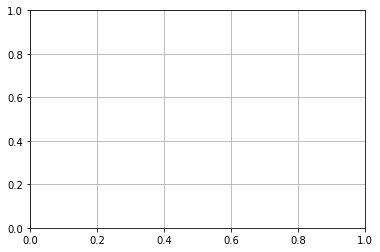

In [19]:
# Benchmark num cem iterations
from mpc import MPC
iters = [0, 1, 2, 3, 4, 5, 10, 15]
new_contact_params = [{}]*len(iters)
new_mpc_params = [{'num_warmstart':i} for i in iters]
#res = benchmark(new_mpc_params,new_contact_params)
plot_benchmark(iters, *res, par_name = "CEM warmstart iterations")


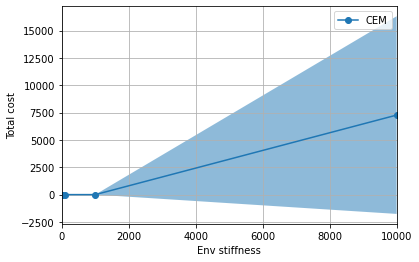

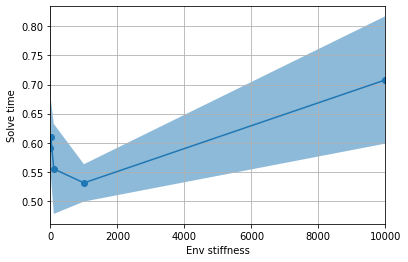

In [22]:
# Increasing stiffness, seems like at K > 2.5e3, we get relative infeasibility for the MPC and the cem warmstart helps a lot
from mpc import MPC
stiffs = [1e0, 1e1, 1e2, 1e3, 1e4]
new_contact_params = [{'models':{'contact_1':{'stiff':[k, 0, 0]}}} for k in stiffs]
new_mpc_params = [{}]*len(stiffs)
#res = benchmark(new_mpc_params,new_contact_params)
plot_benchmark(stiffs, *res, par_name = "Env stiffness")

testing mpc_params {'H': 5} and contact_params {}
{'pos': [0, 0, 0], 'stiff': [7000.0, 0, 0], 'rest': [0.3, 0.18, 0.816]}
Adding contact setpoint cost for contact_1/F


CasADi - 2023-09-09 07:03:14 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]
CasADi - 2023-09-09 07:03:14 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]


testing mpc_params {'H': 10} and contact_params {}
{'pos': [0, 0, 0], 'stiff': [7000.0, 0, 0], 'rest': [0.3, 0.18, 0.816]}
Adding contact setpoint cost for contact_1/F


CasADi - 2023-09-09 07:03:17 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]
CasADi - 2023-09-09 07:03:17 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]


testing mpc_params {'H': 15} and contact_params {}
{'pos': [0, 0, 0], 'stiff': [7000.0, 0, 0], 'rest': [0.3, 0.18, 0.816]}
Adding contact setpoint cost for contact_1/F


CasADi - 2023-09-09 07:03:21 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]
CasADi - 2023-09-09 07:03:21 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]


testing mpc_params {'H': 20} and contact_params {}
{'pos': [0, 0, 0], 'stiff': [7000.0, 0, 0], 'rest': [0.3, 0.18, 0.816]}
Adding contact setpoint cost for contact_1/F


CasADi - 2023-09-09 07:03:27 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]
CasADi - 2023-09-09 07:03:27 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]


testing mpc_params {'H': 25} and contact_params {}
{'pos': [0, 0, 0], 'stiff': [7000.0, 0, 0], 'rest': [0.3, 0.18, 0.816]}


CasADi - 2023-09-09 07:03:36 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]
CasADi - 2023-09-09 07:03:36 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]


Adding contact setpoint cost for contact_1/F
testing mpc_params {'H': 30} and contact_params {}
{'pos': [0, 0, 0], 'stiff': [7000.0, 0, 0], 'rest': [0.3, 0.18, 0.816]}


CasADi - 2023-09-09 07:03:48 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]
CasADi - 2023-09-09 07:03:48 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]


Adding contact setpoint cost for contact_1/F


ValueError: x and y must have same first dimension, but have shapes (5,) and (6,)

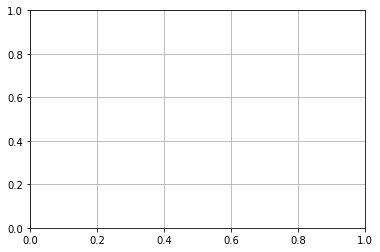

In [23]:
# Increasing planning horizon
from mpc import MPC
Hs = [5, 10, 15, 20, 25, 30]
new_contact_params = [{}]*len(Hs)
new_mpc_params = [{"H":H} for H in Hs]
res = benchmark(new_mpc_params,new_contact_params)
plot_benchmark(stiffs, *res, par_name = "Planning horizon")

testing mpc_params {'num_warmstart': 0} and contact_params {}
Adding contact setpoint cost for contact_1/F


CasADi - 2023-09-09 07:23:31 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]


testing mpc_params {'num_warmstart': 1} and contact_params {}
Adding contact setpoint cost for contact_1/F


CasADi - 2023-09-09 07:23:33 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]


testing mpc_params {'num_warmstart': 2} and contact_params {}
Adding contact setpoint cost for contact_1/F


CasADi - 2023-09-09 07:23:35 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]


testing mpc_params {'num_warmstart': 3} and contact_params {}
Adding contact setpoint cost for contact_1/F


CasADi - 2023-09-09 07:23:38 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]


testing mpc_params {'num_warmstart': 4} and contact_params {}
Adding contact setpoint cost for contact_1/F


CasADi - 2023-09-09 07:23:41 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]


testing mpc_params {'num_warmstart': 5} and contact_params {}
Adding contact setpoint cost for contact_1/F


CasADi - 2023-09-09 07:23:44 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]


testing mpc_params {'num_warmstart': 10} and contact_params {}
Adding contact setpoint cost for contact_1/F


CasADi - 2023-09-09 07:23:47 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]


testing mpc_params {'num_warmstart': 15} and contact_params {}
Adding contact setpoint cost for contact_1/F


CasADi - 2023-09-09 07:23:50 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]


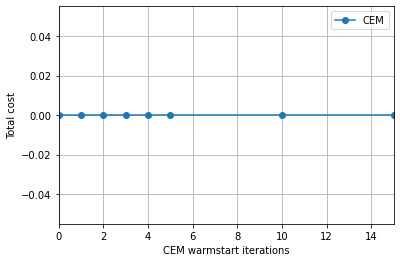

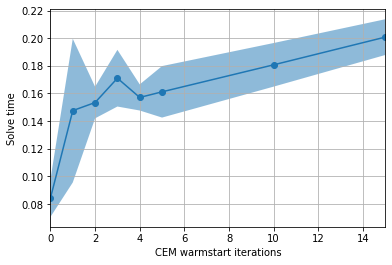

In [25]:
# Switched model, also does well 
from mpc import MPC
iters = [0, 1, 2, 3, 4, 5, 10, 15]
new_contact_params = [{}]*len(iters)
new_mpc_params = [{'num_warmstart':i} for i in iters]
res = benchmark(new_mpc_params,new_contact_params, switched = True)
plot_benchmark(iters, *res, par_name = "CEM warmstart iterations")


In [102]:
mpc, params = spawn_mpc(switched=True, print_level=0)
params['belief_free'] = 1.0
cost, res = mpc.solve(params)
traj = mpc.robots['free'].get_ext_state(res)
print(cost)
print(traj['imp_rest'])
print(traj['F_ext'])

Adding contact setpoint cost for contact_1/F


CasADi - 2023-09-07 21:29:02 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]


20.465
[[-0.56553435  0.31301846  0.37015334  0.30772008  0.27702104  0.2741198
   0.27665652  0.27750004  0.27684159  0.27566388  0.27436803  0.27303908
   0.27170003  0.27037408  0.2690688   0.26773789  0.26629906  0.26498185
   0.26520586  0.26905327]
 [ 0.00655171  0.13971608  0.14201433  0.12209851  0.11246998  0.10968645
   0.10745301  0.10428898  0.10069046  0.09718475  0.09400041  0.09121107
   0.08884263  0.08690335  0.08538613  0.08426919  0.08353722  0.0832554
   0.08362288  0.08447244]
 [ 1.21939736  0.78882123  0.77133291  0.80177455  0.81530804  0.81651141
   0.81569567  0.8158173   0.81665521  0.81774797  0.81892497  0.82015681
   0.82143989  0.82277007  0.8241469   0.82557677  0.82703698  0.82832478
   0.82883252  0.82796716]]
[[0.         0.         0.         8.72899094 7.10970778 5.41217905
  5.03226052 5.10217628 5.16698335 5.17030297 5.14688904 5.11744383
  5.0867932  5.05497275 5.02144382 4.98803542 4.9672802  4.98527263
  5.01344395 4.73362917]
 [0.         0.   